In [10]:
# Configs
%load_ext autoreload
%autoreload 3
import sys
sys.path.insert(0, "../")
from src_code.data_utils.dataset import GridDataset
from src_code.data_utils.dataset_utils import CellType
from src_code.data_utils.prompt_utils import prompt_generator
from src_code.model_utils.gemma3 import Gemma3Model
from src_code.eval_utils.eval import calculate_score, eval_results

import ast

model = Gemma3Model()
EVAL_NUM = 100


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/var/lit2425/humanize/UTN_VLM_reasoning/.venv/lib/python3.10/site-packages/accelerate/utils/modeling.py:1569: UserWarning: Current model requires 33792 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# Example

In [17]:
reuslt = model.inference(
    "Describe this image in detail.", 
    img="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/bee.jpg"
)
print(reuslt)

Okay, here's a detailed description of the image, as if I were a path planner analyzing the scene:

**Overall Scene:**

The image depicts a close-up, natural setting, likely a garden bed. It’s a vibrant, slightly overgrown scene with a focus on flowers and a busy bee. The composition is relatively tight, filling the frame with the central elements.

**Key Elements & Details:**

* **Cosmos Flowers (Pink):** The dominant feature is a


# Our dataset

In [18]:
dataset = GridDataset(grid_size=5, seed = 42, wall_symbol="#", free_symbol=".")

In [19]:
img, grid_world = dataset[10]
prompt_img = prompt_generator(grid_world, pure_language=False, img=True, img_symbol="This image")
print(prompt_img)

This image is an image of a grid world

The red cell is the starting cell,
the green cell is the goal cell,
the gray cells are obstacles,
and the white cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starting cell to the goal cell?



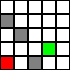

In [20]:
img

# Eval

In [21]:
path_results_img = []
path_results_ascii = []
path_results_coor = []
path_results_img_raw = []
path_results_ascii_raw = []
path_results_coor_raw = []
EVAL_NUM = 100
for i in range(EVAL_NUM):
    img_rgb, grid_world = dataset[i]
    prompt_img = prompt_generator(grid_world, pure_language=False, img=True, img_symbol="This image")
    prompt_ascii = prompt_generator(grid_world, pure_language=False)
    prompt_coor = prompt_generator(grid_world, pure_language=True)
    path_result_img = model.inference(
        prompt_img, 
        img=img_rgb
    )
    patj_result_ascii = model.inference(
        prompt_ascii
    )
    path_result_coor = model.inference(
        prompt_coor
    )
    path_results_img_raw.append(path_result_img)
    path_results_ascii_raw.append(patj_result_ascii)
    path_results_coor_raw.append(path_result_coor)
    try:
        print(f"{path_result_img=}")
        path_result_img = ast.literal_eval(path_result_img)
        print(f"{path_result_img=}")
        path_results_img.append(path_result_img)
    except Exception as e:
        print(f"{e=}")
        print(f"Fail to parse path_result_img")
    try:
        print(f"{patj_result_ascii=}")
        path_result_ascii = ast.literal_eval(patj_result_ascii)
        path_results_ascii.append(path_result_ascii)
        print(f"{path_result_ascii=}")
    except Exception as e:
        print(f"{e=}")
        print(f"Fail to parse path_result_ascii")
    try:
        print(f"{path_result_coor=}")
        path_result_coor = ast.literal_eval(path_result_coor)
        print(f"{path_result_coor=}")
        path_results_coor.append(path_result_coor)
    except Exception as e:
        print(f"{e=}")
        print(f"Fail to parse path_result_coor")
    print(f"{grid_world.a_star()=}\n")

eval_result_img = eval_results(path_results_img, dataset)
eval_result_ascii = eval_results(path_results_ascii, dataset)
eval_result_coor = eval_results(path_results_coor, dataset)
print(f"{eval_result_img=}")
print(f"{eval_result_ascii=}")
print(f"{eval_result_coor=}")
result = {"img": eval_result_img, "ascii": eval_result_ascii, "coor": eval_result_coor}

path_result_img="('go right', 'go right', 'go down', 'go down', 'go left', 'go left', 'go down')"
path_result_img=('go right', 'go right', 'go down', 'go down', 'go left', 'go left', 'go down')
patj_result_ascii="('go right', 'go right', 'go down', 'go right', 'go down', 'go right')"
path_result_ascii=('go right', 'go right', 'go down', 'go right', 'go down', 'go right')
path_result_coor="('go down', 'go left', 'go left', 'go down', 'go down', 'go left')"
path_result_coor=('go down', 'go left', 'go left', 'go down', 'go down', 'go left')
grid_world.a_star()=('go up', 'go up', 'go up', 'go left')

path_result_img="('go right', 'go right', 'go down', 'go down', 'go left', 'go left', 'go down')"
path_result_img=('go right', 'go right', 'go down', 'go down', 'go left', 'go left', 'go down')
patj_result_ascii="('go right', 'go right', 'go right', 'go down', 'go right')\n"
path_result_ascii=('go right', 'go right', 'go right', 'go down', 'go right')
path_result_coor="('go down', 'go left', '

In [22]:
result

{'img': {'success rate (%)': 2.0202020202020203,
  'average collision': 1.2121212121212122,
  'average goal_distance': 5.454545454545454,
  'average path_length_difference': 2.707070707070707},
 'ascii': {'success rate (%)': 0.0,
  'average collision': 1.1616161616161615,
  'average goal_distance': 6.101010101010101,
  'average path_length_difference': 3.090909090909091},
 'coor': {'success rate (%)': 1.0204081632653061,
  'average collision': 1.1326530612244898,
  'average goal_distance': 5.183673469387755,
  'average path_length_difference': 3.306122448979592}}

In [24]:
import json

with open('../result_gemma3_100.json', 'w') as f:
    json.dump(result, f, indent=4)

with open('../gemma3_results_img_raw.json', 'w') as f:
    json.dump(path_results_img_raw, f, indent=4)

with open('../gemma3_results_ascii_raw.json', 'w') as f:
    json.dump(path_results_ascii_raw, f, indent=4)

with open('../gemma3_results_coor_raw.json', 'w') as f:
    json.dump(path_results_coor_raw, f, indent=4)

In [1]:
%load_ext autoreload
%autoreload 3
import sys
sys.path.insert(0, "../")
import json
from src_code.data_utils.dataset import GridDataset
from src_code.eval_utils.eval import calculate_score, eval_results
import ast
dataset = GridDataset(grid_size=5, seed = 42, wall_symbol="#", free_symbol=".")

In [3]:
# read the results
path_results_img = []
path_results_ascii = []
path_results_coor = []
with open('../gemma3_results_img_raw.json', 'r') as f:
    path_results_img_raw = json.load(f)

with open('../gemma3_results_ascii_raw.json', 'r') as f:
    path_results_ascii_raw = json.load(f)

with open('../gemma3_results_coor_raw.json', 'r') as f:
    path_results_coor_raw = json.load(f)

for i, content in enumerate(path_results_img_raw):
    r = None
    try:
        r = ast.literal_eval(content)
        if type(r) == str:
            r = (r,)
    except Exception as e:
        print("Imgae result parsing error")
    path_results_img.append(r)

for i, content in enumerate(path_results_ascii_raw):
    r = None
    try:
        r = ast.literal_eval(content)
        if type(r) == str:
            r = (r,)
    except Exception as e:
        print("Ascii result parsing error")
    path_results_ascii.append(r)

for i, content in enumerate(path_results_coor_raw):
    r = None
    try:
        r = ast.literal_eval(content)
        if type(r) == str:
            r = (r,)
    except Exception as e:
        print("coor result parsing error")
    path_results_coor.append(r)

eval_result_img = eval_results(path_results_img, dataset)
eval_result_ascii = eval_results(path_results_ascii, dataset)
eval_result_coor = eval_results(path_results_coor, dataset)
print(f"{eval_result_img=}")
print(f"{eval_result_ascii=}")
print(f"{eval_result_coor=}")
result = {"img": eval_result_img, "ascii": eval_result_ascii, "coor": eval_result_coor}

Imgae result parsing error
Ascii result parsing error
coor result parsing error
coor result parsing error
Error in evaluating path 77: 'NoneType' object is not iterable
Error in evaluating path 15: 'NoneType' object is not iterable
Error in evaluating path 30: 'NoneType' object is not iterable
Error in evaluating path 37: 'NoneType' object is not iterable
eval_result_img={'success rate (%)': 3.0, 'average collision': 1.18, 'average goal_distance': 5.23, 'average path_length_difference': 2.63, 'pass_through_goal': 4}
eval_result_ascii={'success rate (%)': 1.0, 'average collision': 1.19, 'average goal_distance': 6.06, 'average path_length_difference': 3.22, 'pass_through_goal': 5}
eval_result_coor={'success rate (%)': 2.0, 'average collision': 1.18, 'average goal_distance': 4.87, 'average path_length_difference': 2.95, 'pass_through_goal': 12}
